Notes to the process. Use normal machine learning using all (or some) collected properties of a draw against the result target of the round/game. 
In the application the algorithm then tests the possible options (actions plus card choice if applied on open card) plus the unchangable player, pile appearance and uses the best one.

The current card values of closed (20) and existing (30) mean that linear method do not work. Could use card mean for closed and 0 for existing. That should get most of the effects but not all since the variance of the values matters and vanish is not exatcly the same as zero.

Besides teh top most cards the cards in open pile are ordered by value, because only the top most card can be accessed.
For player reordering is more difficult because the position matters something, since 3 equal cards in a column vanish.

In [7]:
import numpy as np
import random as random
#using simpleguitk for display, is not needed for computer game
import simpleguitk as simplegui
import time
from skyjo_functions1 import *
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import pickle
from xgboost import XGBRegressor

Now testing whether it works here also.

In [8]:
names=['alpha','beta']
nature=['computer','computer']
levels=[0,0]
#random is missing should work is it is setup or class difefrent? 
scores,turns,last_player,numeric,van_count=skyjo_round(names,nature,levels,0,True,True,True) 

As the first step I use the player mode, because it is likely easiest. Secondly, I work on a round, not a match, because while the game is the principual unit, it include some additional complications, but it seems unlikely that they influence the strategy much or at all. 

As the first step I train a predictor to predict the point differential (own points-opponents points).  I use only a subset of the feature information in the first training. I ignore most information of the piles, besides the top most open card, which can be taken. The other information (mainly values of other played cards) is inprinciple useful to know which cards are still in game, but that should be minor modification of main strategy.  The length of the closed pile, is also related to it and is likely just a shortcut it should be possible to get it from other properties also. 

I also ignore the round number since I expect that it only dilutes card state based predictors


In [18]:
names=['alpha','beta']
nature=['computer','computer']
levels=[0,0]
#random is missing should work is it is setup or class difefrent? 
scores,turns,last_player,numeric,van_count=skyjo_round(names,nature,levels,0,True,True,True) 
#selected rows areray
sel1=np.zeros((185))
#open card on pile
print(numeric[1])
sel1[1]=1
#own card set
print(numeric[152:164,0])
sel1[152:164]=1
#other card set
print(numeric[164:176,0])
sel1[164:176]=1
#take open 
print(numeric[176])
sel1[176]=1
#discard
print(numeric[177])
sel1[177]=1
# discarded closed card
print(numeric[178])
sel1[178]=1
#id of selected player card
print(numeric[179])
sel1[179]=1
#number of selected player card
print(numeric[180])
sel1[180]=1
# selected card state
print(numeric[181])
sel1[181]=1
#score, differential is used as target for now included in collection
print(numeric[183])
sel1[183]=1
print(numeric[184])
sel1[184]=1
print(sum(sel1))
print(numeric.shape)
# list of strings which will be pandas header
columns=['open_pile_card']
for i in range(12):
    columns.append('own_cards_'+str(i))
for i in range(12):
    columns.append('other_player_cards_'+str(i))    
columns.append('action_take_open')
columns.append('action_discard')
columns.append('discard_value')
columns.append('id_player_card')
columns.append('value_player_card')
columns.append('state_player_card')               
columns.append('score_self')
columns.append('score_other')
columns.append('round')
print(columns)
print(len(columns))

[ 9 11  7  0  9 11  3  9 -1  6  4  9  9  5  9 -1  4 12  5  4 -1  9 11 10
  9  7 11 -1  0  0 11]
[20 20 20 20 20 20 20  6 20 20 -1 20]
[20 20 20 20 -1 20 20 20 20  4 20 20]
[1 1 1 1 1 1 0 1 0 0 1 1 0 1 1 0 0 1 0 0 1 1 1 1 0 0 0 0 1 0 1]
[0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0 1 0 0 0 1 0]
[30 30 30 30 30 30 10 30  3  4 30 30  5 30 30  6 12 30  4 -1 30 30 30 30
  0 11  1  6 30 11 30]
[ 6  6  4  1  5  5  6  4  7 11  5  3  9  0 10  9  8  0  3  2 10  5  6  8
  0 10 10  2  2  7  5]
[11  7  0  9 11  3  9 -1  6  2  9  9 -1  9 -1  4  7  5  9  0  9 11 10  9
  7  8 -1  0  0  8  4]
[0 0 0 0 0 0 1 1 1 0 1 0 0 0 1 1 0 1 0 0 1 1 1 0 0 0 1 1 0 0 1]
[ 71 180  71 180  71 180  71 180  71 180  71 180  71 180  71 180  71 180
  71 180  71 180  71 180  71 180  71 180  71 180  71]
[180  71 180  71 180  71 180  71 180  71 180  71 180  71 180  71 180  71
 180  71 180  71 180  71 180  71 180  71 180  71 180]
33.0
(185, 31)
['open_pile_card', 'own_cards_0', 'own_cards_1', 'own_cards_2', 'own_cards_3', 

Thus in total it are 31 features and 1 target. 

One round is clearly not enough to train, not only because of the length of here 33 data collections (turns), but also because the data is similar in the different turns. 
Thus, the data from many rounds needs to be collected, I now build a function which does that and also selects the data which will used for training.

In [10]:
#parameters, names, nature, mode of players, pause, first round, silent, collecting data which features selected, for many rounds played 
#column names
def round_for_ml(names,nature,levels,selected_features,nn,column):
    van_count=0
    odd=False
    for i in range(nn):
        print("case "+str(i))
        scores,turns,last_player,numeric,van=skyjo_round(names,nature,levels,0,True,True,True) 
        van_count+=van
        num2=np.zeros((int(sum(selected_features)+1),numeric.shape[1]),int)
        #print(numeric.shape)
        #counter in array
        c=0
        for j in range(numeric.shape[0]):
            if selected_features[j]==1:
                num2[c,:]=np.round(numeric[j,:])
                c+=1
        num2[c,:]=int(i)
        if i==0:
            #create first data frame
            df = pd.DataFrame(data = num2.T, index=range(num2.shape[1]),columns = column)
            #print(df.shape)
        else:
            #create new one of new data
            df2 = pd.DataFrame(data = num2.T, index=range(df.shape[1],df.shape[1]+num2.shape[1]),columns = column)
            #print(df2.shape)
            #merge product is same name as first
            df=pd.concat([df,df2])
            #print(df.shape)
    print(f"number of rows is {df.shape[0]}")        
    print(f"number of vanishing events was {van_count}")    
    return df, van_count        

I run it a number of times to have a lrger enough sample that there is some hope that a prediction is possible. 

In [118]:
start_time=time.time()
df,vancount=round_for_ml(names,nature,levels,sel1,10000,columns)
stop_time=time.time()
print(f"running time was {round(stop_time-start_time,4)} seconds")

case 0
case 1
case 2
case 3
case 4
case 5
case 6
case 7
case 8
case 9
case 10
case 11
case 12
case 13
case 14
case 15
case 16
case 17
case 18
case 19
case 20
case 21
case 22
case 23
case 24
case 25
case 26
case 27
case 28
case 29
case 30
case 31
case 32
case 33
case 34
case 35
case 36
case 37
case 38
case 39
case 40
case 41
case 42
case 43
case 44
case 45
case 46
case 47
case 48
case 49
case 50
case 51
case 52
case 53
case 54
case 55
case 56
case 57
case 58
case 59
case 60
case 61
case 62
case 63
case 64
case 65
case 66
case 67
case 68
case 69
case 70
case 71
case 72
case 73
case 74
case 75
case 76
case 77
case 78
case 79
case 80
case 81
case 82
case 83
case 84
case 85
case 86
case 87
case 88
case 89
case 90
case 91
case 92
case 93
case 94
case 95
case 96
case 97
case 98
case 99
case 100
case 101
case 102
case 103
case 104
case 105
case 106
case 107
case 108
case 109
case 110
case 111
case 112
case 113
case 114
case 115
case 116
case 117
case 118
case 119
case 120
case 121
case 122
cas

case 926
case 927
case 928
case 929
case 930
case 931
case 932
case 933
case 934
case 935
case 936
case 937
case 938
case 939
case 940
case 941
case 942
case 943
case 944
case 945
case 946
case 947
case 948
case 949
case 950
case 951
case 952
case 953
case 954
case 955
case 956
case 957
case 958
case 959
case 960
case 961
case 962
case 963
case 964
case 965
case 966
case 967
case 968
case 969
case 970
case 971
case 972
case 973
case 974
case 975
case 976
case 977
case 978
case 979
case 980
case 981
case 982
case 983
case 984
case 985
case 986
case 987
case 988
case 989
case 990
case 991
case 992
case 993
case 994
case 995
case 996
case 997
case 998
case 999
case 1000
case 1001
case 1002
case 1003
case 1004
case 1005
case 1006
case 1007
case 1008
case 1009
case 1010
case 1011
case 1012
case 1013
case 1014
case 1015
case 1016
case 1017
case 1018
case 1019
case 1020
case 1021
case 1022
case 1023
case 1024
case 1025
case 1026
case 1027
case 1028
case 1029
case 1030
case 1031
case 1032
case

case 1780
case 1781
case 1782
case 1783
case 1784
case 1785
case 1786
case 1787
case 1788
case 1789
case 1790
case 1791
case 1792
case 1793
case 1794
case 1795
case 1796
case 1797
case 1798
case 1799
case 1800
case 1801
case 1802
case 1803
case 1804
case 1805
case 1806
case 1807
case 1808
case 1809
case 1810
case 1811
case 1812
case 1813
case 1814
case 1815
case 1816
case 1817
case 1818
case 1819
case 1820
case 1821
case 1822
case 1823
case 1824
case 1825
case 1826
case 1827
case 1828
case 1829
case 1830
case 1831
case 1832
case 1833
case 1834
case 1835
case 1836
case 1837
case 1838
case 1839
case 1840
case 1841
case 1842
case 1843
case 1844
case 1845
case 1846
case 1847
case 1848
case 1849
case 1850
case 1851
case 1852
case 1853
case 1854
case 1855
case 1856
case 1857
case 1858
case 1859
case 1860
case 1861
case 1862
case 1863
case 1864
case 1865
case 1866
case 1867
case 1868
case 1869
case 1870
case 1871
case 1872
case 1873
case 1874
case 1875
case 1876
case 1877
case 1878
case 1879


case 2616
case 2617
case 2618
case 2619
case 2620
case 2621
case 2622
case 2623
case 2624
case 2625
case 2626
case 2627
case 2628
case 2629
case 2630
case 2631
case 2632
case 2633
case 2634
case 2635
case 2636
case 2637
case 2638
case 2639
case 2640
case 2641
case 2642
case 2643
case 2644
case 2645
case 2646
case 2647
case 2648
case 2649
case 2650
case 2651
case 2652
case 2653
case 2654
case 2655
case 2656
case 2657
case 2658
case 2659
case 2660
case 2661
case 2662
case 2663
case 2664
case 2665
case 2666
case 2667
case 2668
case 2669
case 2670
case 2671
case 2672
case 2673
case 2674
case 2675
case 2676
case 2677
case 2678
case 2679
case 2680
case 2681
case 2682
case 2683
case 2684
case 2685
case 2686
case 2687
case 2688
case 2689
case 2690
case 2691
case 2692
case 2693
case 2694
case 2695
case 2696
case 2697
case 2698
case 2699
case 2700
case 2701
case 2702
case 2703
case 2704
case 2705
case 2706
case 2707
case 2708
case 2709
case 2710
case 2711
case 2712
case 2713
case 2714
case 2715


case 3449
case 3450
case 3451
case 3452
case 3453
case 3454
case 3455
case 3456
case 3457
case 3458
case 3459
case 3460
case 3461
case 3462
case 3463
case 3464
case 3465
case 3466
case 3467
case 3468
case 3469
case 3470
case 3471
case 3472
case 3473
case 3474
case 3475
case 3476
case 3477
case 3478
case 3479
case 3480
case 3481
case 3482
case 3483
case 3484
case 3485
case 3486
case 3487
case 3488
case 3489
case 3490
case 3491
case 3492
case 3493
case 3494
case 3495
case 3496
case 3497
case 3498
case 3499
case 3500
case 3501
case 3502
case 3503
case 3504
case 3505
case 3506
case 3507
case 3508
case 3509
case 3510
case 3511
case 3512
case 3513
case 3514
case 3515
case 3516
case 3517
case 3518
case 3519
case 3520
case 3521
case 3522
case 3523
case 3524
case 3525
case 3526
case 3527
case 3528
case 3529
case 3530
case 3531
case 3532
case 3533
case 3534
case 3535
case 3536
case 3537
case 3538
case 3539
case 3540
case 3541
case 3542
case 3543
case 3544
case 3545
case 3546
case 3547
case 3548


case 4283
case 4284
case 4285
case 4286
case 4287
case 4288
case 4289
case 4290
case 4291
case 4292
case 4293
case 4294
case 4295
case 4296
case 4297
case 4298
case 4299
case 4300
case 4301
case 4302
case 4303
case 4304
case 4305
case 4306
case 4307
case 4308
case 4309
case 4310
case 4311
case 4312
case 4313
case 4314
case 4315
case 4316
case 4317
case 4318
case 4319
case 4320
case 4321
case 4322
case 4323
case 4324
case 4325
case 4326
case 4327
case 4328
case 4329
case 4330
case 4331
case 4332
case 4333
case 4334
case 4335
case 4336
case 4337
case 4338
case 4339
case 4340
case 4341
case 4342
case 4343
case 4344
case 4345
case 4346
case 4347
case 4348
case 4349
case 4350
case 4351
case 4352
case 4353
case 4354
case 4355
case 4356
case 4357
case 4358
case 4359
case 4360
case 4361
case 4362
case 4363
case 4364
case 4365
case 4366
case 4367
case 4368
case 4369
case 4370
case 4371
case 4372
case 4373
case 4374
case 4375
case 4376
case 4377
case 4378
case 4379
case 4380
case 4381
case 4382


case 5106
case 5107
case 5108
case 5109
case 5110
case 5111
case 5112
case 5113
case 5114
case 5115
case 5116
case 5117
case 5118
case 5119
case 5120
case 5121
case 5122
case 5123
case 5124
case 5125
case 5126
case 5127
case 5128
case 5129
case 5130
case 5131
case 5132
case 5133
case 5134
case 5135
case 5136
case 5137
case 5138
case 5139
case 5140
case 5141
case 5142
case 5143
case 5144
case 5145
case 5146
case 5147
case 5148
case 5149
case 5150
case 5151
case 5152
case 5153
case 5154
case 5155
case 5156
case 5157
case 5158
case 5159
case 5160
case 5161
case 5162
case 5163
case 5164
case 5165
case 5166
case 5167
case 5168
case 5169
case 5170
case 5171
case 5172
case 5173
case 5174
case 5175
case 5176
case 5177
case 5178
case 5179
case 5180
case 5181
case 5182
case 5183
case 5184
case 5185
case 5186
case 5187
case 5188
case 5189
case 5190
case 5191
case 5192
case 5193
case 5194
case 5195
case 5196
case 5197
case 5198
case 5199
case 5200
case 5201
case 5202
case 5203
case 5204
case 5205


case 5933
case 5934
case 5935
case 5936
case 5937
case 5938
case 5939
case 5940
case 5941
case 5942
case 5943
case 5944
case 5945
case 5946
case 5947
case 5948
case 5949
case 5950
case 5951
case 5952
case 5953
case 5954
case 5955
case 5956
case 5957
case 5958
case 5959
case 5960
case 5961
case 5962
case 5963
case 5964
case 5965
case 5966
case 5967
case 5968
case 5969
case 5970
case 5971
case 5972
case 5973
case 5974
case 5975
case 5976
case 5977
case 5978
case 5979
case 5980
case 5981
case 5982
case 5983
case 5984
case 5985
case 5986
case 5987
case 5988
case 5989
case 5990
case 5991
case 5992
case 5993
case 5994
case 5995
case 5996
case 5997
case 5998
case 5999
case 6000
case 6001
case 6002
case 6003
case 6004
case 6005
case 6006
case 6007
case 6008
case 6009
case 6010
case 6011
case 6012
case 6013
case 6014
case 6015
case 6016
case 6017
case 6018
case 6019
case 6020
case 6021
case 6022
case 6023
case 6024
case 6025
case 6026
case 6027
case 6028
case 6029
case 6030
case 6031
case 6032


case 6760
case 6761
case 6762
case 6763
case 6764
case 6765
case 6766
case 6767
case 6768
case 6769
case 6770
case 6771
case 6772
case 6773
case 6774
case 6775
case 6776
case 6777
case 6778
case 6779
case 6780
case 6781
case 6782
case 6783
case 6784
case 6785
case 6786
case 6787
case 6788
case 6789
case 6790
case 6791
case 6792
case 6793
case 6794
case 6795
case 6796
case 6797
case 6798
case 6799
case 6800
case 6801
case 6802
case 6803
case 6804
case 6805
case 6806
case 6807
case 6808
case 6809
case 6810
case 6811
case 6812
case 6813
case 6814
case 6815
case 6816
case 6817
case 6818
case 6819
case 6820
case 6821
case 6822
case 6823
case 6824
case 6825
case 6826
case 6827
case 6828
case 6829
case 6830
case 6831
case 6832
case 6833
case 6834
case 6835
case 6836
case 6837
case 6838
case 6839
case 6840
case 6841
case 6842
case 6843
case 6844
case 6845
case 6846
case 6847
case 6848
case 6849
case 6850
case 6851
case 6852
case 6853
case 6854
case 6855
case 6856
case 6857
case 6858
case 6859


case 7588
case 7589
case 7590
case 7591
case 7592
case 7593
case 7594
case 7595
case 7596
case 7597
case 7598
case 7599
case 7600
case 7601
case 7602
case 7603
case 7604
case 7605
case 7606
case 7607
case 7608
case 7609
case 7610
case 7611
case 7612
case 7613
case 7614
case 7615
case 7616
case 7617
case 7618
case 7619
case 7620
case 7621
case 7622
case 7623
case 7624
case 7625
case 7626
case 7627
case 7628
case 7629
case 7630
case 7631
case 7632
case 7633
case 7634
case 7635
case 7636
case 7637
case 7638
case 7639
case 7640
case 7641
case 7642
case 7643
case 7644
case 7645
case 7646
case 7647
case 7648
case 7649
case 7650
case 7651
case 7652
case 7653
case 7654
case 7655
case 7656
case 7657
case 7658
case 7659
case 7660
case 7661
case 7662
case 7663
case 7664
case 7665
case 7666
case 7667
case 7668
case 7669
case 7670
case 7671
case 7672
case 7673
case 7674
case 7675
case 7676
case 7677
case 7678
case 7679
case 7680
case 7681
case 7682
case 7683
case 7684
case 7685
case 7686
case 7687


case 8409
case 8410
case 8411
case 8412
case 8413
case 8414
case 8415
case 8416
case 8417
case 8418
case 8419
case 8420
case 8421
case 8422
case 8423
case 8424
case 8425
case 8426
case 8427
case 8428
case 8429
case 8430
case 8431
case 8432
case 8433
case 8434
case 8435
case 8436
case 8437
case 8438
case 8439
case 8440
case 8441
case 8442
case 8443
case 8444
case 8445
case 8446
case 8447
case 8448
case 8449
case 8450
case 8451
case 8452
case 8453
case 8454
case 8455
case 8456
case 8457
case 8458
case 8459
case 8460
case 8461
case 8462
case 8463
case 8464
case 8465
case 8466
case 8467
case 8468
case 8469
case 8470
case 8471
case 8472
case 8473
case 8474
case 8475
case 8476
case 8477
case 8478
case 8479
case 8480
case 8481
case 8482
case 8483
case 8484
case 8485
case 8486
case 8487
case 8488
case 8489
case 8490
case 8491
case 8492
case 8493
case 8494
case 8495
case 8496
case 8497
case 8498
case 8499
case 8500
case 8501
case 8502
case 8503
case 8504
case 8505
case 8506
case 8507
case 8508


case 9236
case 9237
case 9238
case 9239
case 9240
case 9241
case 9242
case 9243
case 9244
case 9245
case 9246
case 9247
case 9248
case 9249
case 9250
case 9251
case 9252
case 9253
case 9254
case 9255
case 9256
case 9257
case 9258
case 9259
case 9260
case 9261
case 9262
case 9263
case 9264
case 9265
case 9266
case 9267
case 9268
case 9269
case 9270
case 9271
case 9272
case 9273
case 9274
case 9275
case 9276
case 9277
case 9278
case 9279
case 9280
case 9281
case 9282
case 9283
case 9284
case 9285
case 9286
case 9287
case 9288
case 9289
case 9290
case 9291
case 9292
case 9293
case 9294
case 9295
case 9296
case 9297
case 9298
case 9299
case 9300
case 9301
case 9302
case 9303
case 9304
case 9305
case 9306
case 9307
case 9308
case 9309
case 9310
case 9311
case 9312
case 9313
case 9314
case 9315
case 9316
case 9317
case 9318
case 9319
case 9320
case 9321
case 9322
case 9323
case 9324
case 9325
case 9326
case 9327
case 9328
case 9329
case 9330
case 9331
case 9332
case 9333
case 9334
case 9335


I run 10000 rounds which result into more 330000 turns. that was done in 146 seconds, thus larger data sets should be able to generate.

I save the results and look on the point differential as function of the played card of the player. 

Text(0, 0.5, 'mean point differential')

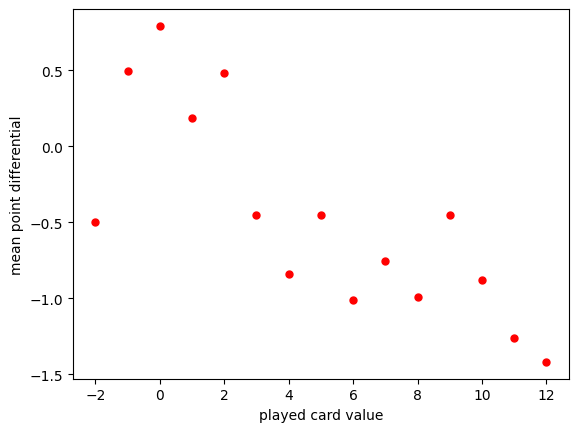

In [124]:
df.to_pickle('level0_10000.pkl')

# read a pickled object from disk ("unpickle it")
df=pd.read_pickle('level0_10000.pkl')

df2=df.groupby(df.value_player_card).mean()
df2=df2.reset_index()
#plt.plot(df['open_pile_card'],df['score_self']-df['score_other'],'o',ms=1,color='blue',label='open card value') 
plt.plot(df2['value_player_card'],df2['score_self']-df2['score_other'],'o',ms=5,color='red') 
#plt.legend(loc="best")
plt.xlabel("played card value")
plt.ylabel("mean point differential")

There is a correlation but its not strong because there are very different kinds of turns summarized under played cards.

I now apply machine learning methods. Test and train cannot be obtained randomly because turns of the game game are more correlated than otherwise.
I define a function which splits currectly and return also targets and feature. 

In [37]:
#parameters feature target, controll series (only split on none equal, split 1(between >0 and <1), optional split2 (if 1 not done)
def split_test(feature,target,controll,split_1,split_2=1):
    #only split into two sets in this case
    if split_2==1:
        xx=round(split_1*feature.shape[0])
        print(xx)
        #first is always larger but not so important for the sizes here 
        while controll.iat[xx-1]==controll.iat[xx]:
            xx+=1
        print(xx)    
        feature_train=feature.iloc[0:xx,:]    
        feature_test=feature.iloc[xx:feature.shape[0],:]
        target_train=target.iloc[0:xx]    
        target_test=target.iloc[xx:feature.shape[0]]        
        return feature_train, feature_test, target_train, target_test
    else:
        xx=round(split_1*feature.shape[0])
        print(xx)
        while controll.iat[xx-1]==controll.iat[xx]:
            xx+=1
        print(xx)
        yy=round(split_2*feature.shape[0])
        print(yy)        
        #first is always larger but not so important for the sizes here 
        while controll.iat[yy-1]==controll.iat[yy]:
            yy+=1
        print(yy)    
        feature_train=feature.iloc[0:xx,:]    
        feature_test=feature.iloc[xx:yy,:]
        feature_valid=feature.iloc[yy:feature.shape[0],:]        
        target_train=target.iloc[0:xx]    
        target_test=target.iloc[xx:yy]      
        target_valid=target.iloc[yy:feature.shape[0]]        
        return feature_train, feature_test, feature_valid, target_train, target_test, target_valid    

In [207]:
feature_train,feature_test,feature_valid,target_train,target_test,target_valid=split_test(df.iloc[:,0:31],df.score_self-df.score_other,df.loc[:,'round'],0.5,0.8)

165074
165087
264118
264123


In [208]:
print(feature_train.shape,feature_test.shape,feature_valid.shape)

(165087, 31) (99036, 31) (66024, 31)


In [209]:
print(feature_train.head)

<bound method NDFrame.head of     open_pile_card  own_cards_0  own_cards_1  own_cards_2  own_cards_3  \
0                0           20           20           20           20   
1                2           20           20           20           20   
2                7           20           20           20           20   
3               -1           20           20           20           20   
4                5            7           20           20           20   
..             ...          ...          ...          ...          ...   
60               9           10           20            6            7   
61               0            6           20            8            8   
62               6           10           20            6            7   
63               1            0           20            8            8   
64              -2           10           20            6            7   

    own_cards_4  own_cards_5  own_cards_6  own_cards_7  own_cards_8  ...  \
0    

Applying XGBRegressor.

In [212]:
start_time=time.time()
regx=XGBRegressor().fit(feature_train, target_train)
stop_time=time.time()
print(f"Took {round(stop_time-start_time,4)} seconds")

Took 5.363 seconds


Is clearly faster than generating the data, which took 146 seconds. Both is fine. 

In [213]:
predli1tex=regx.predict(feature_test)
predli1trx=regx.predict(feature_train)

In [215]:
print(f"standard deviation of test sample {round(np.std(target_test),4)} points")
print(f"standard deviation of train sample {round(np.std(target_train),4)}  points")
print(f"standard deviation of test {round(np.std(predli1tex-target_test),4)} points")
print(f"standard deviation of train {round(np.std(predli1trx-target_train),4)} points")

standard deviation of test sample 63.8887 points
standard deviation of train sample 64.2412  points
standard deviation of test 60.6675 points
standard deviation of train 47.058 points


There is an improvement in both test and train, but it is clearly bigger in train. 

In [217]:
start_time=time.time()
regx2=XGBRegressor(subsample=0.5,min_child_weight=4).fit(feature_train, target_train)
stop_time=time.time()
print(f"Took {round(stop_time-start_time,4)} seconds")

Took 7.3013 seconds


In [219]:
predli1tex2=regx2.predict(feature_test)
predli1trx2=regx2.predict(feature_train)

In [220]:
print(f"standard deviation of test sample {round(np.std(target_test),4)} points")
print(f"standard deviation of train sample {round(np.std(target_train),4)}  points")
print(f"standard deviation of test {round(np.std(predli1tex2-target_test),4)} points")
print(f"standard deviation of train {round(np.std(predli1trx2-target_train),4)} points")

standard deviation of test sample 63.8887 points
standard deviation of train sample 64.2412  points
standard deviation of test 61.0105 points
standard deviation of train 47.7344 points


In [223]:
#regulariazation
res=np.zeros((3,20))
for i in range(20):
    print(i)
    res[0,i]=5**i
    regx3=XGBRegressor(reg_alpha=res[0,i]).fit(feature_train, target_train)
    predli1tex3=regx3.predict(feature_test)
    predli1trx3=regx3.predict(feature_train)
    res[1,i]=np.std(predli1tex3-target_test)
    res[2,i]=np.std(predli1trx3-target_train)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [222]:
print(res)

[[  1.           5.          25.         125.        ]
 [ 60.68452091  60.48946256  60.52590861  60.37023114]
 [ 46.93472793  47.02714909  47.22841953  47.09898617]]


Text(0, 0.5, 'standard deviation (data/prediction)')

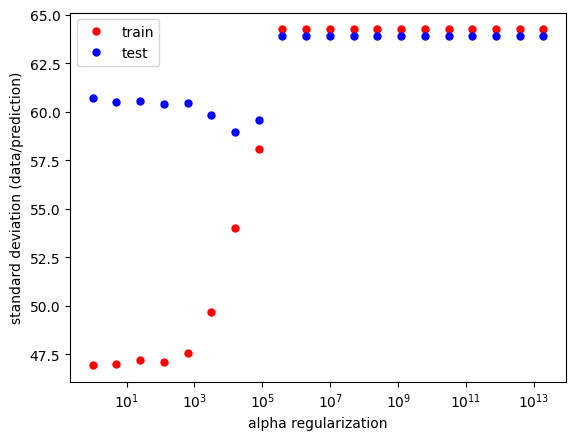

In [228]:
plt.plot(res[0],res[2],'o',ms=5,color='red',label='train') 
plt.plot(res[0],res[1],'o',ms=5,color='blue',label='test') 
plt.legend(loc="best")
plt.xscale("log")
plt.xlabel("alpha regularization")
plt.ylabel("standard deviation (data/prediction)")

There seems to be a rather clear minimum around 10000. Now exploring more.

In [233]:
res=np.zeros((3,20))
for i in range(20):
    print(i)
    res[0,i]=1000*1.41**i
    regx3=XGBRegressor(reg_alpha=res[0,i]).fit(feature_train, target_train)
    predli1tex3=regx3.predict(feature_test)
    predli1trx3=regx3.predict(feature_train)
    res[1,i]=np.std(predli1tex3-target_test)
    res[2,i]=np.std(predli1trx3-target_train)
np.savetxt('xgb_alpha_trial1.txt', res)    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [43]:

res2=np.loadtxt('xgb_alpha_trial1.txt')

Text(0, 0.5, 'standard deviation (data/prediction)')

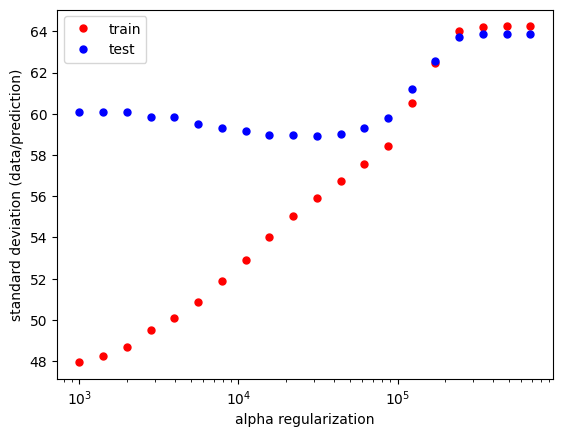

In [45]:
plt.plot(res2[0],res2[2],'o',ms=5,color='red',label='train') 
plt.plot(res2[0],res2[1],'o',ms=5,color='blue',label='test') 
plt.legend(loc="best")
plt.xscale("log")
plt.xlabel("alpha regularization")
plt.ylabel("standard deviation (data/prediction)")

Seems o.k. but also is clearly better in train than test, thus something is not ideal. Likely not yet enough data used. Thus,
I generate more data 10 times more now. In one piece slow, it sems mainly because of the data saving way. Thus, I do in pieces of 10000.

In [15]:
start_time=time.time()
df,vancount=round_for_ml(names,nature,levels,sel1,10,columns)
stop_time=time.time()
print(f"running time was {round(stop_time-start_time,4)} seconds")
df.to_csv('level0_10its_10.csv')  
#seems to get slower must be the attaching of data not the simulation itself 
#dom in 10000 bits
print(df)
dfb=pd.read_table('level0_10its_10.csv',index=True)
print(dfb)

case 0
case 1
case 2
case 3
case 4
case 5
case 6
case 7
case 8
case 9
number of rows is 311
number of vanishing events was 3
running time was 0.0356 seconds
    open_pile_card  own_cards_0  own_cards_1  own_cards_2  own_cards_3  \
0               10           20           20           20            6   
1                3           20           20           20           20   
2                4           20           20           10            6   
3               -2           20           20           20            0   
4                0           20           20           10            6   
..             ...          ...          ...          ...          ...   
59               9            5           20            0           20   
60               0           -1            8           -1           11   
61               8            5           20            0           20   
62               0           -1            0           -1           11   
63              -1           

In [3]:
#something wrong with load start with comma and gets into a single row 
df1=pd.read_table('level0_10000its_1.csv')
df2=pd.read_table('level0_10000its_2.csv')
df3=pd.read_table('level0_10000its_3.csv')
df4=pd.read_table('level0_10000its_4.csv')
df5=pd.read_table('level0_10000its_5.csv')
#df6=pd.read_table('level0_10000its_6.csv')
#df7=pd.read_table('level0_10000its_7.csv')
#df8=pd.read_table('level0_10000its_8.csv')
#df9=pd.read_table('level0_10000its_9.csv')
#df10=pd.read_table('level0_10000its_10.csv')
print(df1.head())

  ,open_pile_card,own_cards_0,own_cards_1,own_cards_2,own_cards_3,own_cards_4,own_cards_5,own_cards_6,own_cards_7,own_cards_8,own_cards_9,own_cards_10,own_cards_11,other_player_cards_0,other_player_cards_1,other_player_cards_2,other_player_cards_3,other_player_cards_4,other_player_cards_5,other_player_cards_6,other_player_cards_7,other_player_cards_8,other_player_cards_9,other_player_cards_10,other_player_cards_11,action_take_open,action_discard,discard_value,id_player_card,value_player_card,state_player_card,score_self,score_other,round
0  0,12,8,20,20,20,12,20,20,20,20,20,20,20,20,12,...                                                                                                                                                                                                                                                                                                                                                                                                                    

Could maybe only use (save?) a single turn of all of a round. 

In [5]:
#10 seem too many that it works  
#both have wrong shape something wrong with saving the csv 
df=pd.concat([df1,df2,df3,df4,df5],join='outer', ignore_index=True)
print(df1.shape,df.shape)

(329469, 1) (1645044, 1)


In [30]:
#selects a single random row
def round_for_ml_sel(names,nature,levels,selected_features,nn,column):
    van_count=0
    odd=False
    for i in range(nn):
        print("case "+str(i))
        scores,turns,last_player,numeric,van=skyjo_round(names,nature,levels,0,True,True,True) 
        van_count+=van
        num2=np.zeros((int(sum(selected_features)+1),1),int)
        #print(numeric.shape)
        #counter in array
        c=0
        b=random.randrange(numeric.shape[1])
        for j in range(numeric.shape[0]):
            if selected_features[j]==1:
                num2[c,0]=np.round(numeric[j,b])
                c+=1
        num2[c,0]=int(i)
        if i==0:
            #create first data frame
            df = pd.DataFrame(data = num2.T, index=range(num2.shape[1]),columns = column)
            #print(df.shape)
        else:
            #create new one of new data
            df2 = pd.DataFrame(data = num2.T, index=range(df.shape[1],df.shape[1]+num2.shape[1]),columns = column)
            #print(df2.shape)
            #merge product is same name as first
            df=pd.concat([df,df2])
            #print(df.shape)
    print(f"number of rows is {df.shape[0]}")        
    print(f"number of vanishing events was {van_count}")    
    return df, van_count        

In [ ]:
start_time=time.time()
df,van=round_for_ml_sel(names,nature,levels,sel1,100000,columns)
df.to_pickle('level_rand_0_100000_2.pkl')
stop_time=time.time()
print(f"calculation needed {round(stop_time-start_time,4)} seconds")
#but not all vanishing vents are really selected 
#starts to get slower due to merging now , thus not

case 0
case 1
case 2
case 3
case 4
case 5
case 6
case 7
case 8
case 9
case 10
case 11
case 12
case 13
case 14
case 15
case 16
case 17
case 18
case 19
case 20
case 21
case 22
case 23
case 24
case 25
case 26
case 27
case 28
case 29
case 30
case 31
case 32
case 33
case 34
case 35
case 36
case 37
case 38
case 39
case 40
case 41
case 42
case 43
case 44
case 45
case 46
case 47
case 48
case 49
case 50
case 51
case 52
case 53
case 54
case 55
case 56
case 57
case 58
case 59
case 60
case 61
case 62
case 63
case 64
case 65
case 66
case 67
case 68
case 69
case 70
case 71
case 72
case 73
case 74
case 75
case 76
case 77
case 78
case 79
case 80
case 81
case 82
case 83
case 84
case 85
case 86
case 87
case 88
case 89
case 90
case 91
case 92
case 93
case 94
case 95
case 96
case 97
case 98
case 99
case 100
case 101
case 102
case 103
case 104
case 105
case 106
case 107
case 108
case 109
case 110
case 111
case 112
case 113
case 114
case 115
case 116
case 117
case 118
case 119
case 120
case 121
case 122
cas

case 984
case 985
case 986
case 987
case 988
case 989
case 990
case 991
case 992
case 993
case 994
case 995
case 996
case 997
case 998
case 999
case 1000
case 1001
case 1002
case 1003
case 1004
case 1005
case 1006
case 1007
case 1008
case 1009
case 1010
case 1011
case 1012
case 1013
case 1014
case 1015
case 1016
case 1017
case 1018
case 1019
case 1020
case 1021
case 1022
case 1023
case 1024
case 1025
case 1026
case 1027
case 1028
case 1029
case 1030
case 1031
case 1032
case 1033
case 1034
case 1035
case 1036
case 1037
case 1038
case 1039
case 1040
case 1041
case 1042
case 1043
case 1044
case 1045
case 1046
case 1047
case 1048
case 1049
case 1050
case 1051
case 1052
case 1053
case 1054
case 1055
case 1056
case 1057
case 1058
case 1059
case 1060
case 1061
case 1062
case 1063
case 1064
case 1065
case 1066
case 1067
case 1068
case 1069
case 1070
case 1071
case 1072
case 1073
case 1074
case 1075
case 1076
case 1077
case 1078
case 1079
case 1080
case 1081
case 1082
case 1083
case 1084
case 1

case 1865
case 1866
case 1867
case 1868
case 1869
case 1870
case 1871
case 1872
case 1873
case 1874
case 1875
case 1876
case 1877
case 1878
case 1879
case 1880
case 1881
case 1882
case 1883
case 1884
case 1885
case 1886
case 1887
case 1888
case 1889
case 1890
case 1891
case 1892
case 1893
case 1894
case 1895
case 1896
case 1897
case 1898
case 1899
case 1900
case 1901
case 1902
case 1903
case 1904
case 1905
case 1906
case 1907
case 1908
case 1909
case 1910
case 1911
case 1912
case 1913
case 1914
case 1915
case 1916
case 1917
case 1918
case 1919
case 1920
case 1921
case 1922
case 1923
case 1924
case 1925
case 1926
case 1927
case 1928
case 1929
case 1930
case 1931
case 1932
case 1933
case 1934
case 1935
case 1936
case 1937
case 1938
case 1939
case 1940
case 1941
case 1942
case 1943
case 1944
case 1945
case 1946
case 1947
case 1948
case 1949
case 1950
case 1951
case 1952
case 1953
case 1954
case 1955
case 1956
case 1957
case 1958
case 1959
case 1960
case 1961
case 1962
case 1963
case 1964


case 2759
case 2760
case 2761
case 2762
case 2763
case 2764
case 2765
case 2766
case 2767
case 2768
case 2769
case 2770
case 2771
case 2772
case 2773
case 2774
case 2775
case 2776
case 2777
case 2778
case 2779
case 2780
case 2781
case 2782
case 2783
case 2784
case 2785
case 2786
case 2787
case 2788
case 2789
case 2790
case 2791
case 2792
case 2793
case 2794
case 2795
case 2796
case 2797
case 2798
case 2799
case 2800
case 2801
case 2802
case 2803
case 2804
case 2805
case 2806
case 2807
case 2808
case 2809
case 2810
case 2811
case 2812
case 2813
case 2814
case 2815
case 2816
case 2817
case 2818
case 2819
case 2820
case 2821
case 2822
case 2823
case 2824
case 2825
case 2826
case 2827
case 2828
case 2829
case 2830
case 2831
case 2832
case 2833
case 2834
case 2835
case 2836
case 2837
case 2838
case 2839
case 2840
case 2841
case 2842
case 2843
case 2844
case 2845
case 2846
case 2847
case 2848
case 2849
case 2850
case 2851
case 2852
case 2853
case 2854
case 2855
case 2856
case 2857
case 2858


case 3624
case 3625
case 3626
case 3627
case 3628
case 3629
case 3630
case 3631
case 3632
case 3633
case 3634
case 3635
case 3636
case 3637
case 3638
case 3639
case 3640
case 3641
case 3642
case 3643
case 3644
case 3645
case 3646
case 3647
case 3648
case 3649
case 3650
case 3651
case 3652
case 3653
case 3654
case 3655
case 3656
case 3657
case 3658
case 3659
case 3660
case 3661
case 3662
case 3663
case 3664
case 3665
case 3666
case 3667
case 3668
case 3669
case 3670
case 3671
case 3672
case 3673
case 3674
case 3675
case 3676
case 3677
case 3678
case 3679
case 3680
case 3681
case 3682
case 3683
case 3684
case 3685
case 3686
case 3687
case 3688
case 3689
case 3690
case 3691
case 3692
case 3693
case 3694
case 3695
case 3696
case 3697
case 3698
case 3699
case 3700
case 3701
case 3702
case 3703
case 3704
case 3705
case 3706
case 3707
case 3708
case 3709
case 3710
case 3711
case 3712
case 3713
case 3714
case 3715
case 3716
case 3717
case 3718
case 3719
case 3720
case 3721
case 3722
case 3723


case 4510
case 4511
case 4512
case 4513
case 4514
case 4515
case 4516
case 4517
case 4518
case 4519
case 4520
case 4521
case 4522
case 4523
case 4524
case 4525
case 4526
case 4527
case 4528
case 4529
case 4530
case 4531
case 4532
case 4533
case 4534
case 4535
case 4536
case 4537
case 4538
case 4539
case 4540
case 4541
case 4542
case 4543
case 4544
case 4545
case 4546
case 4547
case 4548
case 4549
case 4550
case 4551
case 4552
case 4553
case 4554
case 4555
case 4556
case 4557
case 4558
case 4559
case 4560
case 4561
case 4562
case 4563
case 4564
case 4565
case 4566
case 4567
case 4568
case 4569
case 4570
case 4571
case 4572
case 4573
case 4574
case 4575
case 4576
case 4577
case 4578
case 4579
case 4580
case 4581
case 4582
case 4583
case 4584
case 4585
case 4586
case 4587
case 4588
case 4589
case 4590
case 4591
case 4592
case 4593
case 4594
case 4595
case 4596
case 4597
case 4598
case 4599
case 4600
case 4601
case 4602
case 4603
case 4604
case 4605
case 4606
case 4607
case 4608
case 4609


case 5383
case 5384
case 5385
case 5386
case 5387
case 5388
case 5389
case 5390
case 5391
case 5392
case 5393
case 5394
case 5395
case 5396
case 5397
case 5398
case 5399
case 5400
case 5401
case 5402
case 5403
case 5404
case 5405
case 5406
case 5407
case 5408
case 5409
case 5410
case 5411
case 5412
case 5413
case 5414
case 5415
case 5416
case 5417
case 5418
case 5419
case 5420
case 5421
case 5422
case 5423
case 5424
case 5425
case 5426
case 5427
case 5428
case 5429
case 5430
case 5431
case 5432
case 5433
case 5434
case 5435
case 5436
case 5437
case 5438
case 5439
case 5440
case 5441
case 5442
case 5443
case 5444
case 5445
case 5446
case 5447
case 5448
case 5449
case 5450
case 5451
case 5452
case 5453
case 5454
case 5455
case 5456
case 5457
case 5458
case 5459
case 5460
case 5461
case 5462
case 5463
case 5464
case 5465
case 5466
case 5467
case 5468
case 5469
case 5470
case 5471
case 5472
case 5473
case 5474
case 5475
case 5476
case 5477
case 5478
case 5479
case 5480
case 5481
case 5482


In [35]:
df=df=pd.read_pickle('level_rand_0_100000_1.pkl')
print(df)

    open_pile_card  own_cards_0  own_cards_1  own_cards_2  own_cards_3  \
0               11            2            3           20            9   
34               8           20            1           20           20   
34               0            1            3           10           20   
34               1            3            8           20            1   
34               7           20           12           20           -2   
..             ...          ...          ...          ...          ...   
34               0           20           20           20           20   
34               6            2           20            9           20   
34              12            6           20            4            9   
34              -1            6           20            8            3   
34               2           20            3           20           20   

    own_cards_4  own_cards_5  own_cards_6  own_cards_7  own_cards_8  ...  \
0             0           20       

In [38]:
feature_train,feature_test,feature_valid,target_train,target_test,target_valid=split_test(df.iloc[:,0:31],df.score_self-df.score_other,df.loc[:,'round'],0.5,0.8)

50000
50000
80000
80000


In [40]:
start_time=time.time()
regxl=XGBRegressor().fit(feature_train, target_train)
stop_time=time.time()
print(f"Took {round(stop_time-start_time,4)} seconds")

Took 1.5747 seconds


In [41]:
predli1texl=regx.predict(feature_test)
predli1trxl=regx.predict(feature_train)

In [42]:
print(f"standard deviation of test sample {round(np.std(target_test),4)} points")
print(f"standard deviation of train sample {round(np.std(target_train),4)}  points")
print(f"standard deviation of test {round(np.std(predli1texl-target_test),4)} points")
print(f"standard deviation of train {round(np.std(predli1trxl-target_train),4)} points")

standard deviation of test sample 64.5336 points
standard deviation of train sample 64.6309  points
standard deviation of test 59.6529 points
standard deviation of train 47.8628 points


Train is a little worse, test is better as expected that performs better at least usually. (less clear on n_vanishing events)

In [47]:
resb=np.zeros((3,20))
for i in range(20):
    print(i)
    resb[0,i]=1000*1.41**i
    regx3=XGBRegressor(reg_alpha=resb[0,i]).fit(feature_train, target_train)
    predli1tex3=regx3.predict(feature_test)
    predli1trx3=regx3.predict(feature_train)
    resb[1,i]=np.std(predli1tex3-target_test)
    resb[2,i]=np.std(predli1trx3-target_train)
np.savetxt('xgbb_alpha_trial1.txt', resb)    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


Text(0, 0.5, 'standard deviation (data/prediction)')

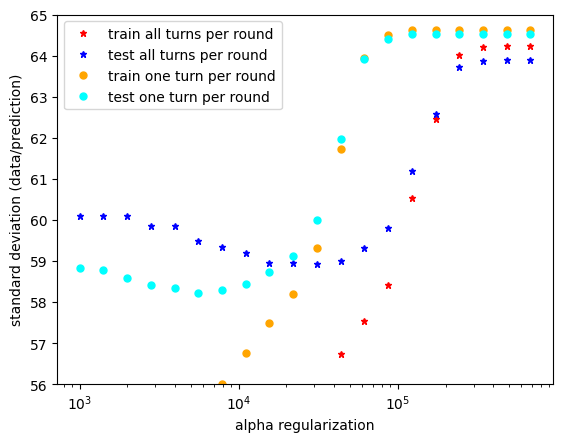

In [52]:
resb=np.loadtxt('xgbb_alpha_trial1.txt')
plt.plot(res2[0],res2[2],'*',ms=5,color='red',label='train all turns per round') 
plt.plot(res2[0],res2[1],'*',ms=5,color='blue',label='test all turns per round') 
plt.plot(resb[0],resb[2],'o',ms=5,color='orange',label='train one turn per round') 
plt.plot(resb[0],resb[1],'o',ms=5,color='cyan',label='test one turn per round') 
plt.legend(loc="best")
plt.xscale("log")
plt.ylim(56,65)
plt.xlabel("alpha regularization")
plt.ylabel("standard deviation (data/prediction)")

The minimum is better as expected, the smaller correlation in the data helps a lot, given that the data set is much smaller now. Also the basline here is worse, the scatter is higher for really large regularization. 